Import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from scipy.signal import butter, lfilter

from sklearn.preprocessing import StandardScaler

%matplotlib inline

Reading the accelerometer and gyroscope data of the top sensor, applying z-normalization

In [2]:
top_acc_data = pd.read_csv('data/acc_top.csv')
top_acc_data.columns = ['timestamp', 'seconds', 'top_acc_z', 'top_acc_y', 'top_acc_x']
top_gyr_data = pd.read_csv('data/gyr_top.csv')
top_gyr_data.columns = ['timestamp', 'seconds', 'top_gyr_z', 'top_gyr_y', 'top_gyr_x']
top_data = pd.concat([top_acc_data, top_gyr_data[['top_gyr_z', 'top_gyr_y', 'top_gyr_x']]], axis=1)
top_data.to_csv('data/raw_top_data.csv', index=False)
top_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49419 entries, 0 to 49418
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  49419 non-null  int64  
 1   seconds    49419 non-null  float64
 2   top_acc_z  49419 non-null  float64
 3   top_acc_y  49419 non-null  float64
 4   top_acc_x  49419 non-null  float64
 5   top_gyr_z  49419 non-null  float64
 6   top_gyr_y  49419 non-null  float64
 7   top_gyr_x  49419 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 3.0 MB


In [3]:
normalized_data = (top_data - top_data.mean()) / top_data.std()
normalized_data[['timestamp', 'seconds']] = top_data[['timestamp', 'seconds']]
top_data = normalized_data

Reading the accelerometer and gyroscope data of the down sensor, applying z-normalization

In [4]:
down_acc_data = pd.read_csv('data/acc_down.csv')
down_acc_data.columns = ['timestamp', 'seconds', 'down_acc_z', 'down_acc_y', 'down_acc_x']
down_gyr_data = pd.read_csv('data/gyr_down.csv')
down_gyr_data.columns = ['timestamp', 'seconds', 'down_gyr_z', 'down_gyr_y', 'down_gyr_x']
down_data = pd.concat([down_acc_data, down_gyr_data[['down_gyr_z', 'down_gyr_y', 'down_gyr_x']]], axis=1)
down_data.to_csv('data/raw_down_data.csv', index=False)
down_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49777 entries, 0 to 49776
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   49777 non-null  int64  
 1   seconds     49777 non-null  float64
 2   down_acc_z  49777 non-null  float64
 3   down_acc_y  49777 non-null  float64
 4   down_acc_x  49777 non-null  float64
 5   down_gyr_z  49777 non-null  float64
 6   down_gyr_y  49777 non-null  float64
 7   down_gyr_x  49777 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 3.0 MB


In [5]:
normalized_data = (down_data - down_data.mean()) / down_data.std()
normalized_data[['timestamp', 'seconds']] = down_data[['timestamp', 'seconds']]
down_data = normalized_data

Function for plotting the stability of the data sampling frequency

In [6]:
def plot_stability(time_diffs):
    plt.figure(figsize=(6, 3))
    sns.barplot(x=list(range(len(time_diffs))), y=time_diffs, color='slategrey', lw=0.)
    plt.ylabel('Time, sec')
    plt.xticks([])
    plt.title('Stability of Data Collection\nAverage frequency: {:.2f} Hz'.format(1.0 / time_diffs.mean()))
    plt.show()

In [7]:
top_data['seconds'].diff()[top_data['seconds'].diff() > 0.021]

13    0.029995
Name: seconds, dtype: float64

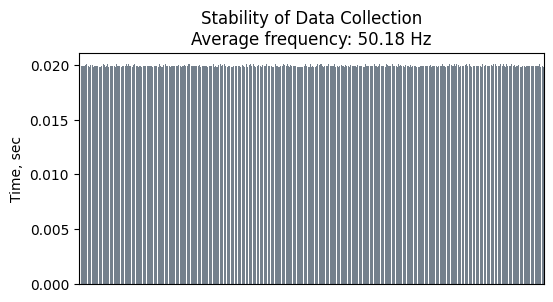

In [8]:
plot_stability(top_data['seconds'].diff()[top_data['seconds'].diff() < 0.021])

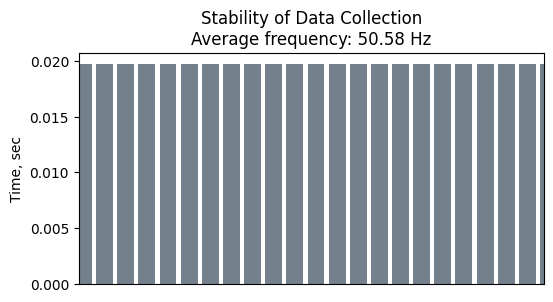

In [9]:
plot_stability(down_data['seconds'].diff())

* One of the sensors lacked the ability to pick up data in a completely stable manner, so the data will need to be adjusted

Function for labeling a dataset after processing in the **Label Studio**

In [10]:
def labeling(file_name, df, index):
    label_df = pd.read_csv(file_name)
    label_list = json.loads(label_df['label'][index])
    labels = []
    for index, row in df.iterrows():
        time = row['timestamp']
        label_found = False
        for item in label_list:
            start_time = item['start']
            end_time = item['end']
            timeseries_labels = item['timeserieslabels']
            if start_time <= time <= end_time:
                labels.append(', '.join(timeseries_labels))
                label_found = True
                break
        if not label_found:
            labels.append('Undefined')
    return labels

In [11]:
down_data['label'] = labeling('data/labels.csv', down_data, 0)
top_data['label'] = labeling('data/labels.csv', top_data, 1)

Manual synchronization of collected data

In [12]:
result_df = pd.DataFrame(columns=['label',
                                  'top_acc_x', 'top_acc_y', 'top_acc_z', 
                                  'top_gyr_x', 'top_gyr_y', 'top_gyr_z',
                                  'down_acc_x', 'down_acc_y', 'down_acc_z', 
                                  'down_gyr_x', 'down_gyr_y', 'down_gyr_z'])

top_columns = ['label', 'top_acc_x', 'top_acc_y', 'top_acc_z', 'top_gyr_x', 'top_gyr_y', 'top_gyr_z']
down_columns = ['down_acc_x', 'down_acc_y', 'down_acc_z', 'down_gyr_x', 'down_gyr_y', 'down_gyr_z']
result_df = pd.concat([result_df, pd.concat([top_data[top_data['label'] == 'Straight'].iloc[66:-6][top_columns].reset_index(drop=True), 
                        down_data[down_data['label'] == 'Straight'].iloc[:-115][down_columns].reset_index(drop=True)], axis=1)], ignore_index=0)
result_df = pd.concat([result_df, pd.concat([top_data[top_data['label'] == 'Curved'].iloc[67:-69][top_columns].reset_index(drop=True), 
                        down_data[down_data['label'] == 'Curved'].iloc[:-158][down_columns].reset_index(drop=True)], axis=1)], ignore_index=0)
result_df = pd.concat([result_df, pd.concat([top_data[top_data['label'] == 'Leaning'].iloc[:-26][top_columns].reset_index(drop=True), 
                        down_data[down_data['label'] == 'Leaning'].iloc[50:-106][down_columns].reset_index(drop=True)], axis=1)], ignore_index=0)
result_df = pd.concat([result_df, pd.concat([top_data[top_data['label'] == 'Tilt'].iloc[50:-36][top_columns].reset_index(drop=True), 
                        down_data[down_data['label'] == 'Tilt'].iloc[:-42][down_columns].reset_index(drop=True)], axis=1)], ignore_index=0)
result_df = pd.concat([result_df, pd.concat([top_data[top_data['label'] == 'Reaching'].iloc[49:-62][top_columns].reset_index(drop=True), 
                        down_data[down_data['label'] == 'Reaching'].iloc[:-186][down_columns].reset_index(drop=True)], axis=1)], ignore_index=0)

result_df.to_csv('data/raw_data.csv', index=False)

Function for plotting the dependence of value on time. With its help it is possible to see the difference in different types of activity with the naked eye

In [13]:
def plot_time_dependence(df, column_names, y_label, title):
    fig, axs = plt.subplots(3, 1, figsize=(18, 6), sharex=True)
    custom_palette = sns.color_palette("mako", n_colors=6)
    label_changes = np.where(df['label'].values[:-1] != df['label'].values[1:])[0]
    segments = np.split(df, label_changes + 1)
    for segment in segments:
        if len(segment) > 0:
            label = segment.iloc[0]['label']
            color = custom_palette[list(df['label'].unique()).index(label)]
            axs[0].plot(segment['timestamp'], segment[column_names[0]], label=label, color=color)
            axs[1].plot(segment['timestamp'], segment[column_names[1]], label=label, color=color)
            axs[2].plot(segment['timestamp'], segment[column_names[2]], label=label, color=color)
            
    labels = df['label'].unique()
    handles = [plt.Line2D([0], [0], color=custom_palette[i], label=labels[i]) for i in range(len(labels))]
    axs[1].set_ylabel(y_label, fontsize=14)
    for ax in axs:
        ax.set_xticklabels([])
        ax.grid()
    fig.legend(handles=handles)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

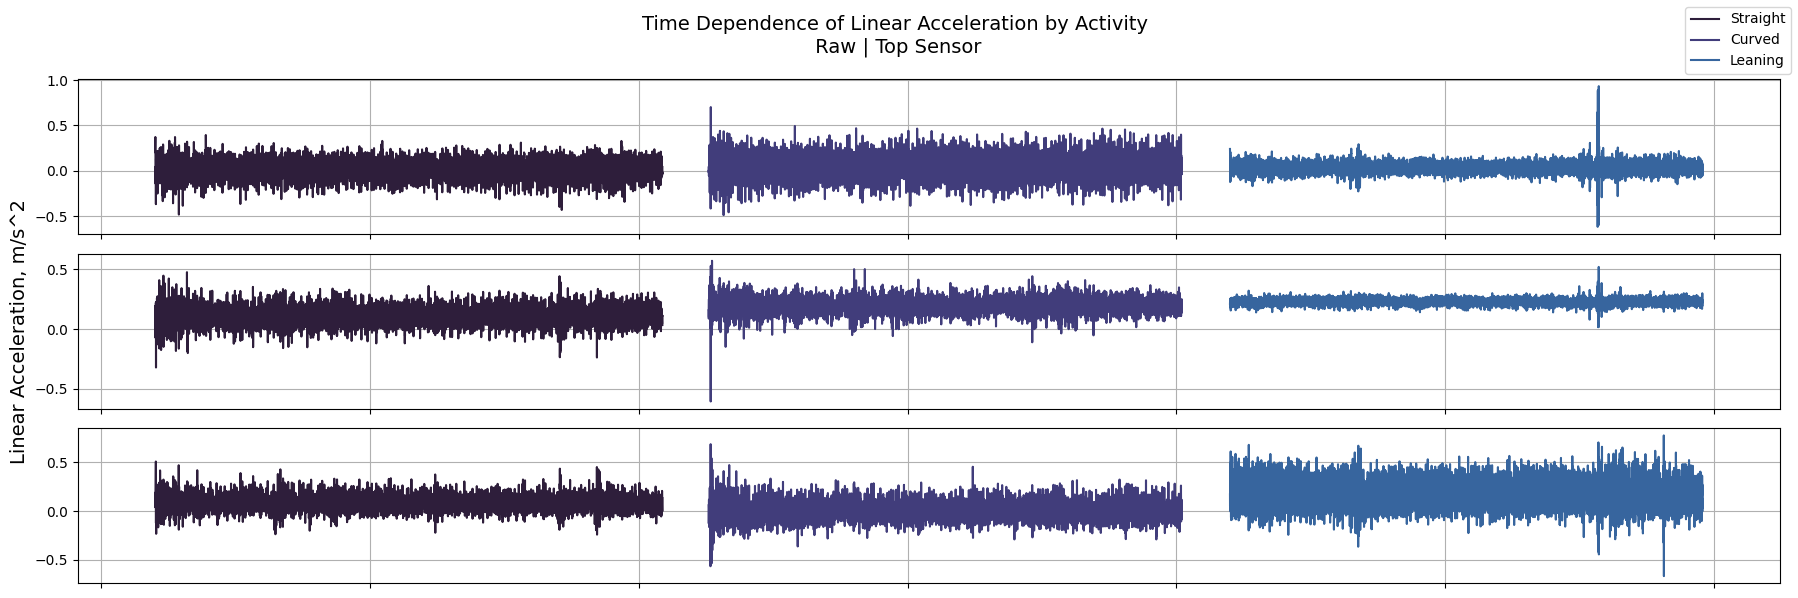

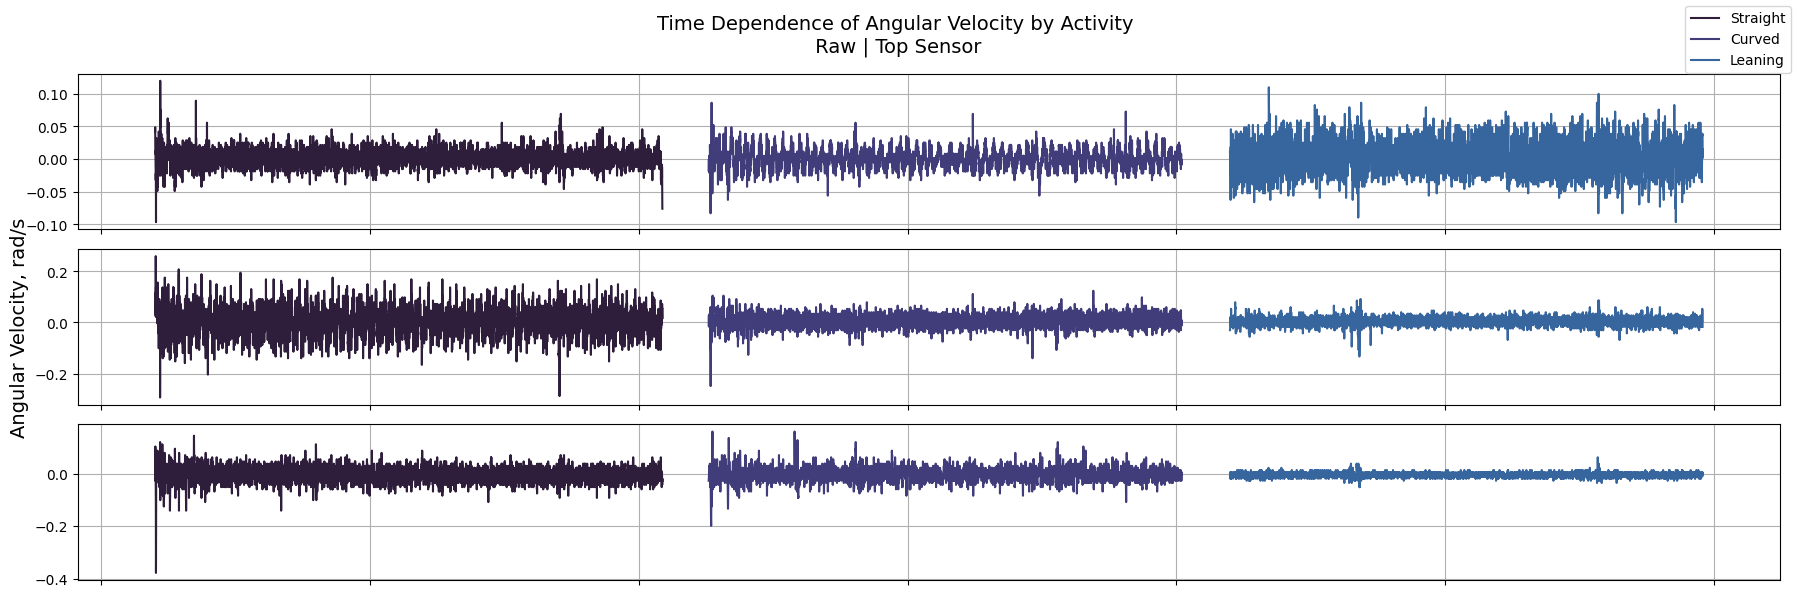

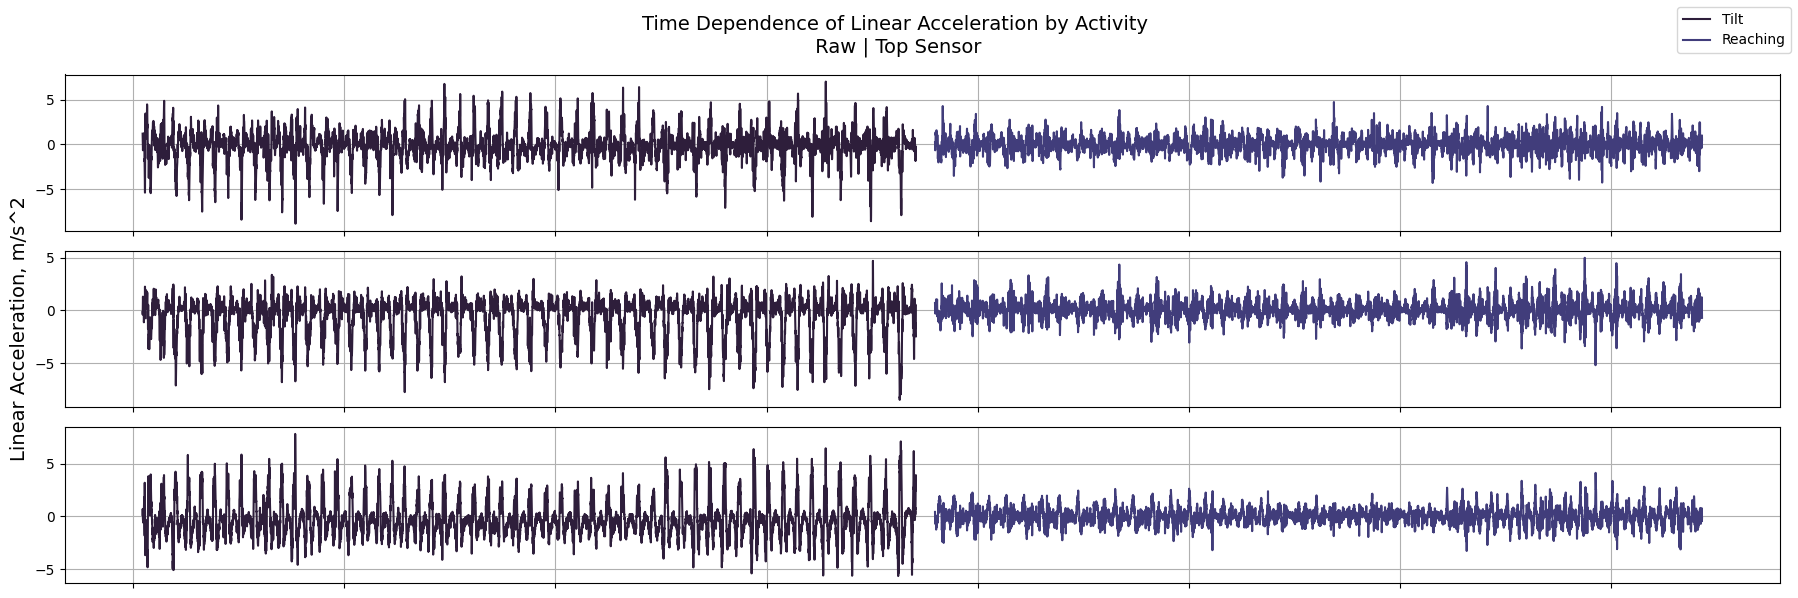

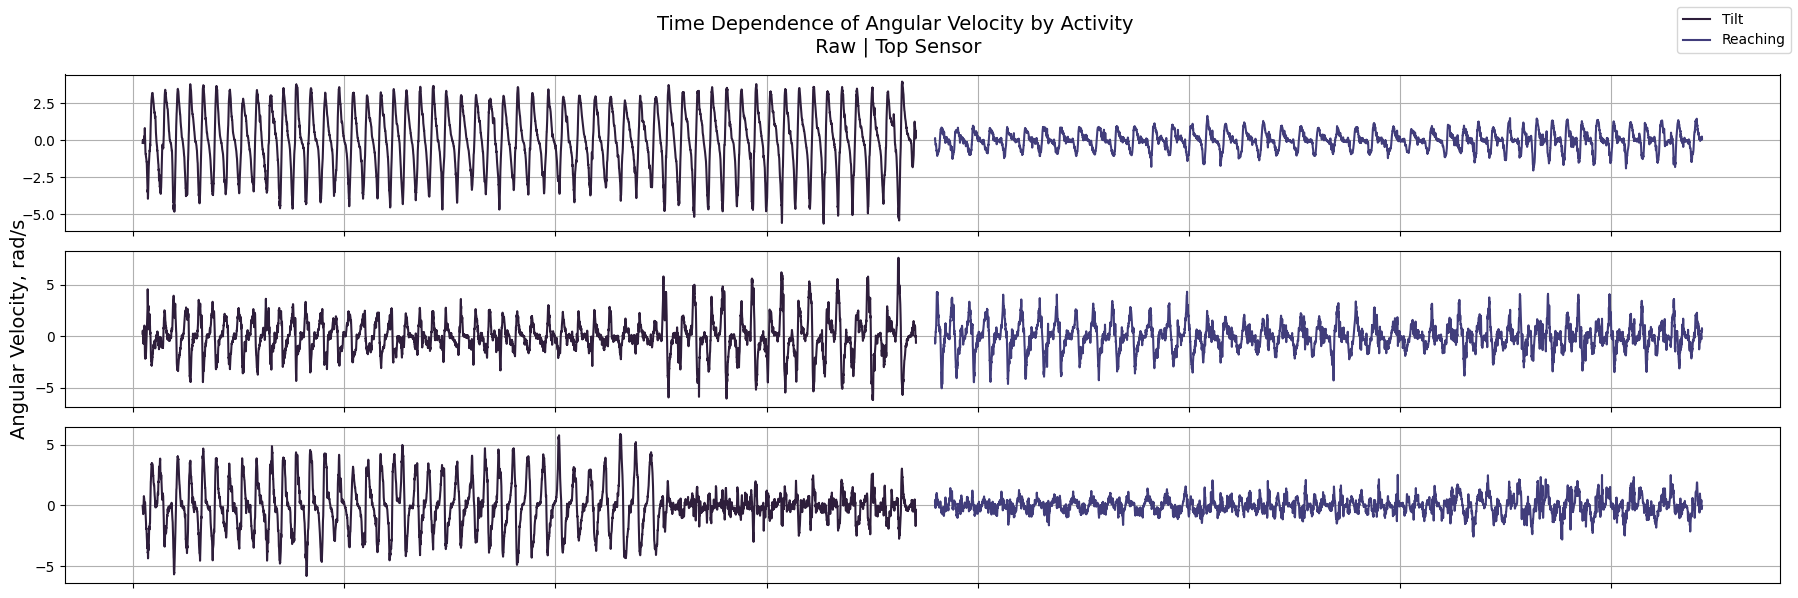

In [14]:
plot_time_dependence(top_data[(top_data['label'] != 'Tilt') & (top_data['label'] != 'Reaching') & (top_data['label'] != 'Undefined')], ['top_acc_x', 'top_acc_y', 'top_acc_z'], 'Linear Acceleration, m/s^2', 'Time Dependence of Linear Acceleration by Activity\n Raw | Top Sensor')
plot_time_dependence(top_data[(top_data['label'] != 'Tilt') & (top_data['label'] != 'Reaching') & (top_data['label'] != 'Undefined')], ['top_gyr_x', 'top_gyr_y', 'top_gyr_z'], 'Angular Velocity, rad/s', 'Time Dependence of Angular Velocity by Activity\n Raw | Top Sensor')
plot_time_dependence(top_data[(top_data['label'] == 'Tilt') | (top_data['label'] == 'Reaching') & (top_data['label'] != 'Undefined')], ['top_acc_x', 'top_acc_y', 'top_acc_z'], 'Linear Acceleration, m/s^2', 'Time Dependence of Linear Acceleration by Activity\n Raw | Top Sensor')
plot_time_dependence(top_data[(top_data['label'] == 'Tilt') | (top_data['label'] == 'Reaching') & (top_data['label'] != 'Undefined')], ['top_gyr_x', 'top_gyr_y', 'top_gyr_z'], 'Angular Velocity, rad/s', 'Time Dependence of Angular Velocity by Activity\n Raw | Top Sensor')

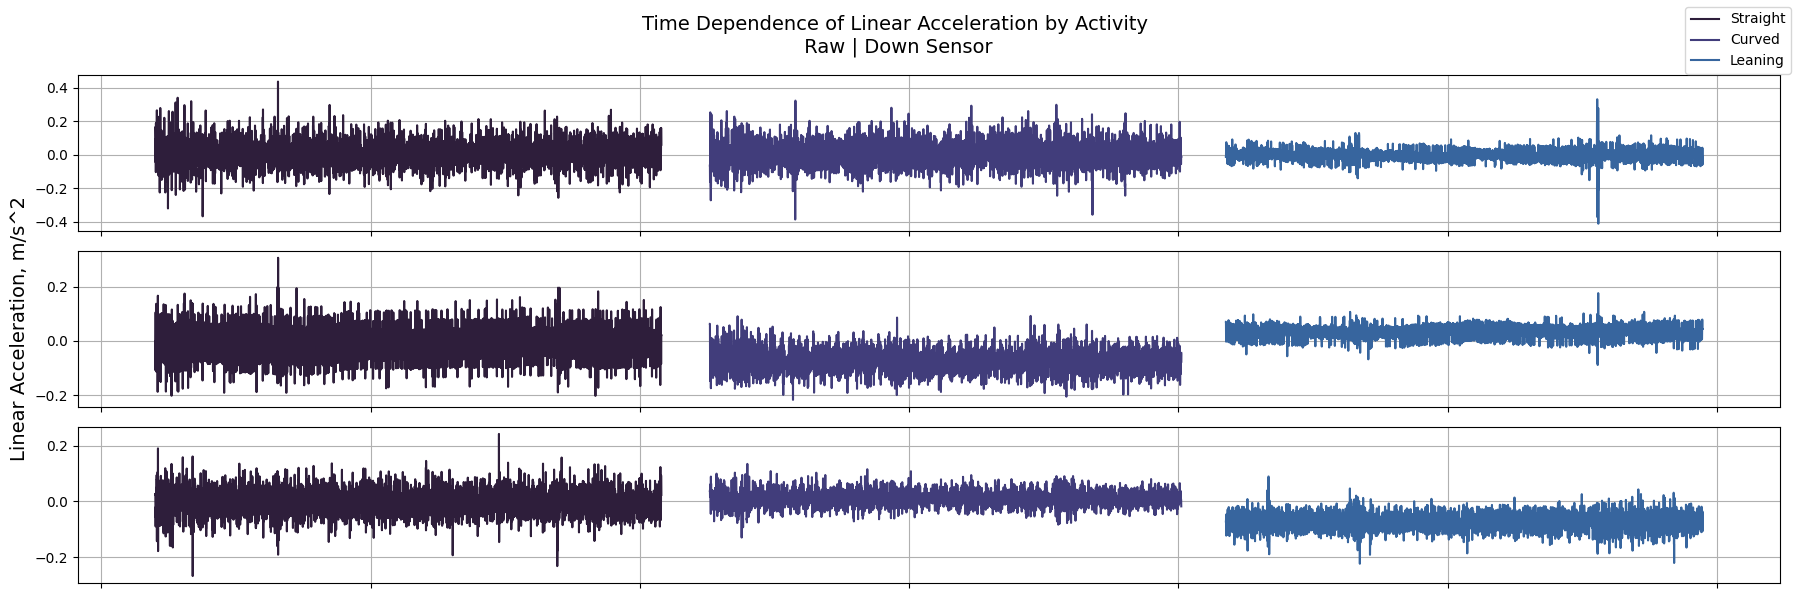

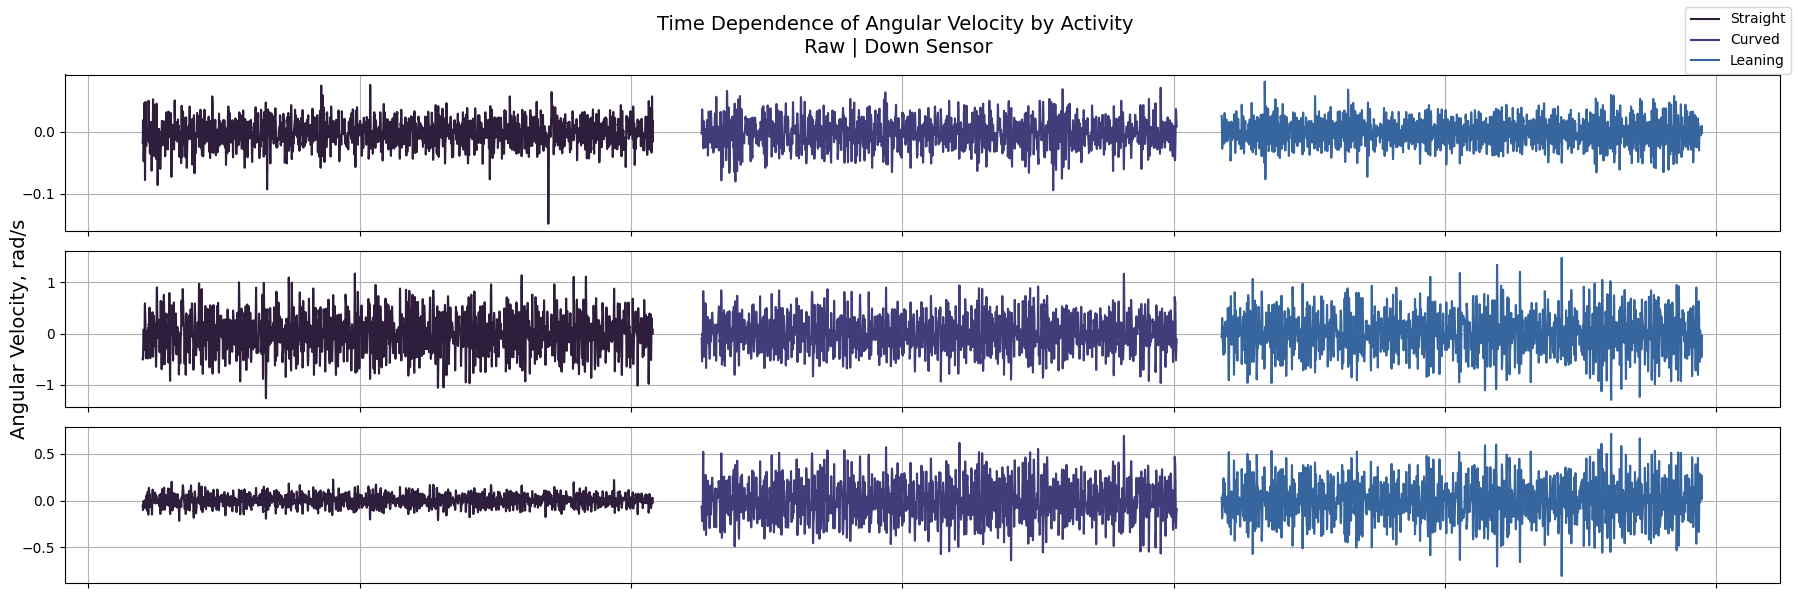

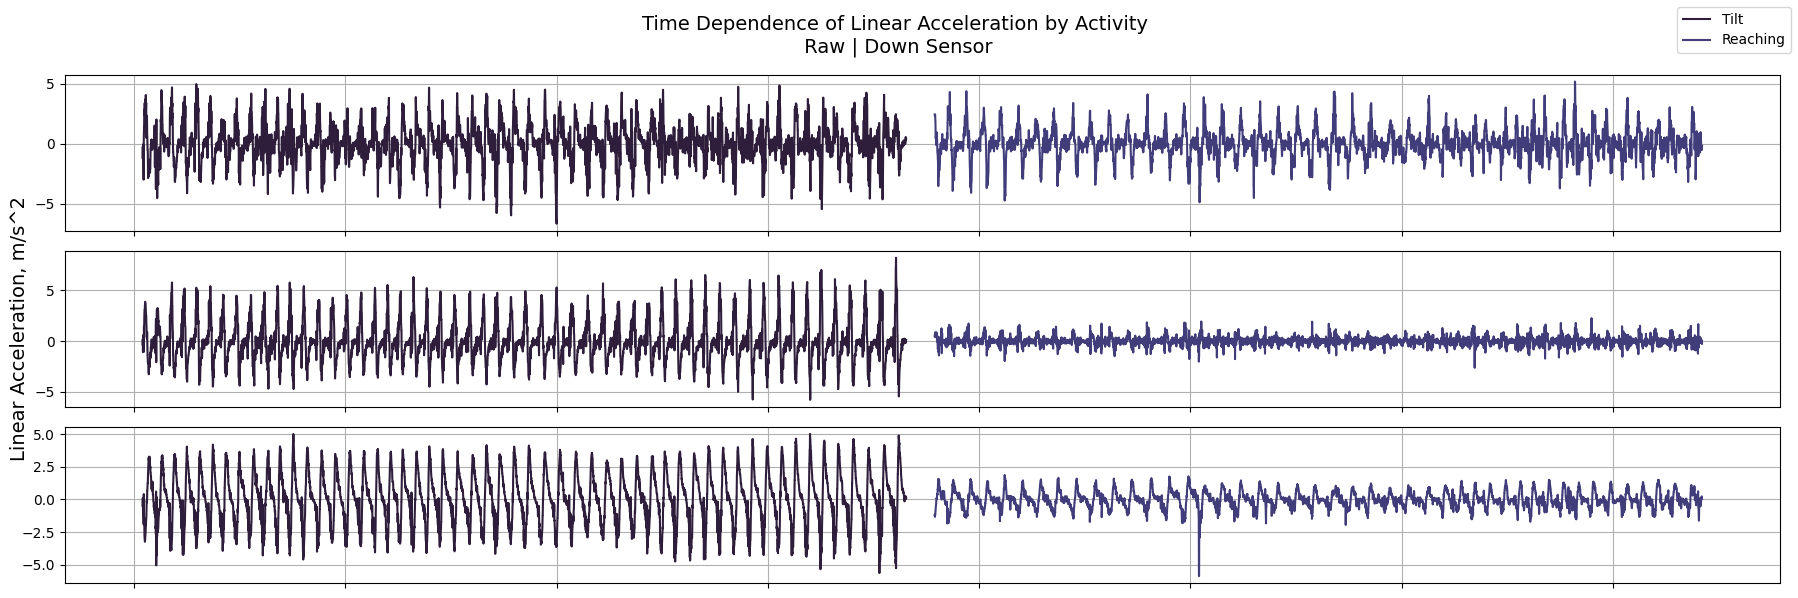

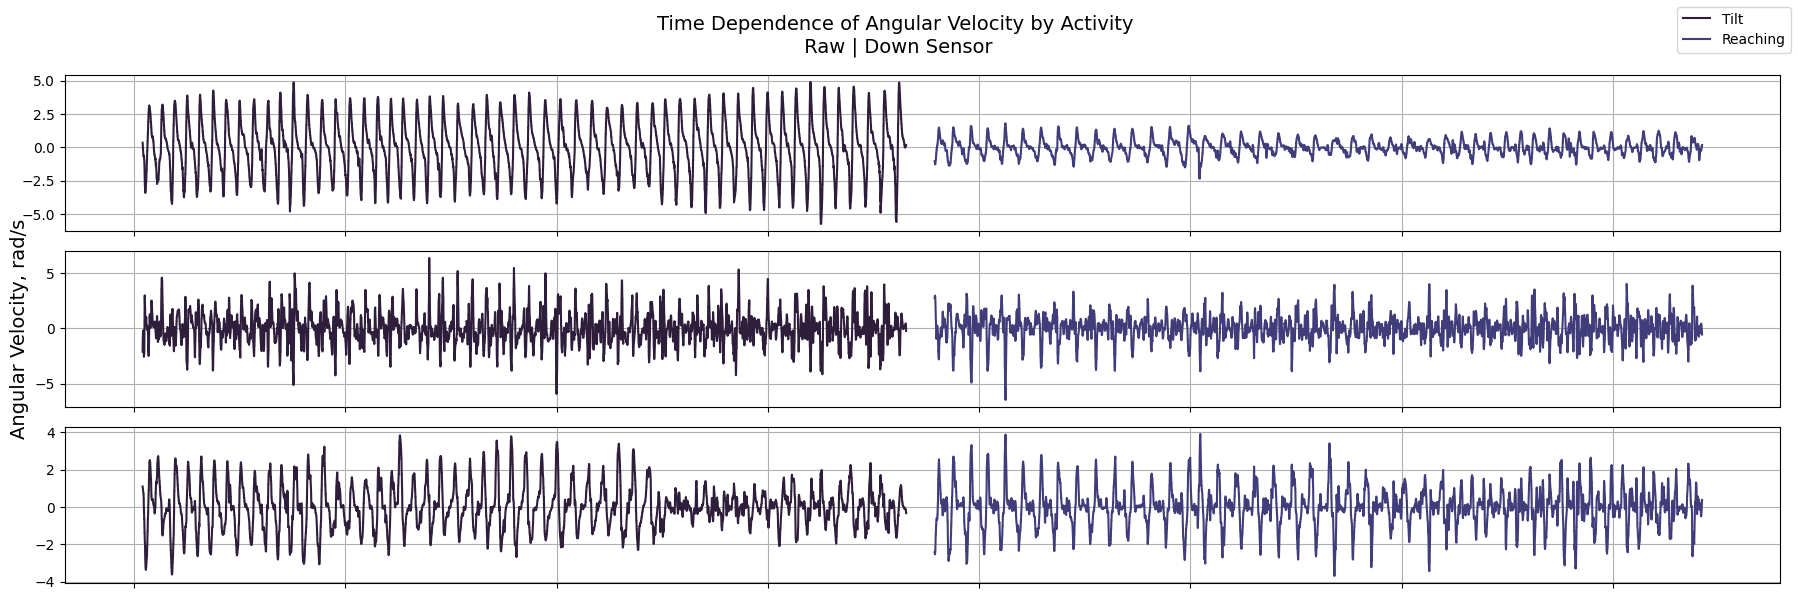

In [15]:
plot_time_dependence(down_data[(down_data['label'] != 'Tilt') & (down_data['label'] != 'Reaching') & (down_data['label'] != 'Undefined')], ['down_acc_x', 'down_acc_y', 'down_acc_z'], 'Linear Acceleration, m/s^2', 'Time Dependence of Linear Acceleration by Activity\n Raw | Down Sensor')
plot_time_dependence(down_data[(down_data['label'] != 'Tilt') & (down_data['label'] != 'Reaching') & (down_data['label'] != 'Undefined')], ['down_gyr_x', 'down_gyr_y', 'down_gyr_z'], 'Angular Velocity, rad/s', 'Time Dependence of Angular Velocity by Activity\n Raw | Down Sensor')
plot_time_dependence(down_data[(down_data['label'] == 'Tilt') | (down_data['label'] == 'Reaching') & (down_data['label'] != 'Undefined')], ['down_acc_x', 'down_acc_y', 'down_acc_z'], 'Linear Acceleration, m/s^2', 'Time Dependence of Linear Acceleration by Activity\n Raw | Down Sensor')
plot_time_dependence(down_data[(down_data['label'] == 'Tilt') | (down_data['label'] == 'Reaching') & (down_data['label'] != 'Undefined')], ['down_gyr_x', 'down_gyr_y', 'down_gyr_z'], 'Angular Velocity, rad/s', 'Time Dependence of Angular Velocity by Activity\n Raw | Down Sensor')

The Kalman filter is a mathematical algorithm used to process data from various sensors, including the accelerometer and gyroscope, to improve the quality of system state estimates and reduce noise

In [16]:
class KalmanFilter:
    def __init__(self, initial_state, initial_covariance, process_noise, 
                 measurement_noise, transition_matrix, observation_matrix):
        # Initialization of state and covariance
        self.state = initial_state
        self.covariance = initial_covariance
        # Process noise and measurement noise matrices
        self.process_noise = process_noise
        self.measurement_noise = measurement_noise
        # Transition and observation matrices
        self.transition_matrix = transition_matrix
        self.observation_matrix = observation_matrix
    def predict(self):
        # State prediction
        self.state = np.dot(self.transition_matrix, self.state)
        # Covariance prediction
        self.covariance = np.dot(np.dot(self.transition_matrix, self.covariance), 
                                 self.transition_matrix.T) + self.process_noise
    def update(self, measurement):
        # Calculation of the measurement error
        measurement_residual = measurement - np.dot(self.observation_matrix, self.state)
        # Calculating the Kalman matrix
        kalman_gain = np.dot(np.dot(self.covariance, self.observation_matrix.T), 
                             np.linalg.inv(np.dot(np.dot(self.observation_matrix, self.covariance), 
                                                  self.observation_matrix.T) + self.measurement_noise))
        # State update
        self.state = self.state + np.dot(kalman_gain, measurement_residual)
        # Covariance update
        self.covariance = self.covariance - np.dot(np.dot(kalman_gain, self.observation_matrix), 
                                                   self.covariance)


Initialization of initial parameters and data filtering

In [17]:
initial_state = np.zeros(6)              # Initial state
initial_covariance = np.identity(6)      # Initial covariance
process_noise = np.identity(6) * 0.01    # Process noise matrix
measurement_noise = np.identity(6) * 0.1 # Measurement noise matrix
transition_matrix = np.identity(6)       # Transition matrix
observation_matrix = np.identity(6)      # Observation matrix

kalman_filter = KalmanFilter(initial_state, initial_covariance, process_noise, measurement_noise, transition_matrix, observation_matrix)

top_filtered_data = []
for index, row in top_data.iterrows():
    measurement = row[['top_acc_x', 'top_acc_y', 'top_acc_z', 'top_gyr_x', 'top_gyr_y', 'top_gyr_z']].values
    kalman_filter.predict()
    kalman_filter.update(measurement)
    top_filtered_data.append(kalman_filter.state)

In [18]:
top_filtered_df = pd.DataFrame(top_filtered_data, columns=['ftop_acc_x', 'ftop_acc_y', 'ftop_acc_z', 
                                                           'ftop_gyr_x', 'ftop_gyr_y', 'ftop_gyr_z'])
top_filtered_df = pd.concat([top_data[['label', 'timestamp']], top_filtered_df], axis=1)

In [19]:
initial_state = np.zeros(6)              # Initial state
initial_covariance = np.identity(6)      # Initial covariance
process_noise = np.identity(6) * 0.01    # Process noise matrix
measurement_noise = np.identity(6) * 0.1 # Measurement noise matrix
transition_matrix = np.identity(6)       # Transition matrix
observation_matrix = np.identity(6)      # Observation matrix

kalman_filter = KalmanFilter(initial_state, initial_covariance, process_noise, measurement_noise, transition_matrix, observation_matrix)

down_filtered_data = []
for index, row in down_data.iterrows():
    measurement = row[['down_acc_x', 'down_acc_y', 'down_acc_z', 'down_gyr_x', 'down_gyr_y', 'down_gyr_z']].values
    kalman_filter.predict()
    kalman_filter.update(measurement)
    down_filtered_data.append(kalman_filter.state)

In [20]:
down_filtered_df = pd.DataFrame(down_filtered_data, columns=['fdown_acc_x', 'fdown_acc_y', 'fdown_acc_z', 
                                                           'fdown_gyr_x', 'fdown_gyr_y', 'fdown_gyr_z'])
down_filtered_df = pd.concat([down_data[['label', 'timestamp']], down_filtered_df], axis=1)

A Butterworth filter is another type of filter used to process signals, including those from an accelerometer and gyroscope. The Butterworth filter is a linear filter with coefficients that are optimized to provide a rectangular frequency spectrum, which means that it does not use weights at different frequencies and has a rectangular amplitude response

In [21]:
def butter_lowpass_filter(data, cutoff_freq, sample_rate, order=5):
    nyquist_freq = 0.5 * sample_rate
    normal_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data)
    return filtered_data

cutoff_frequency = 10 # Filter cutoff frequency (Hz)
sample_rate = 120 # Sample rate (Hz)

Demonstration of the difference between classes after applying filters

In [22]:
for column in top_filtered_df.columns[2:]:
    top_filtered_df[column] = butter_lowpass_filter(top_filtered_df[column], cutoff_frequency, sample_rate)

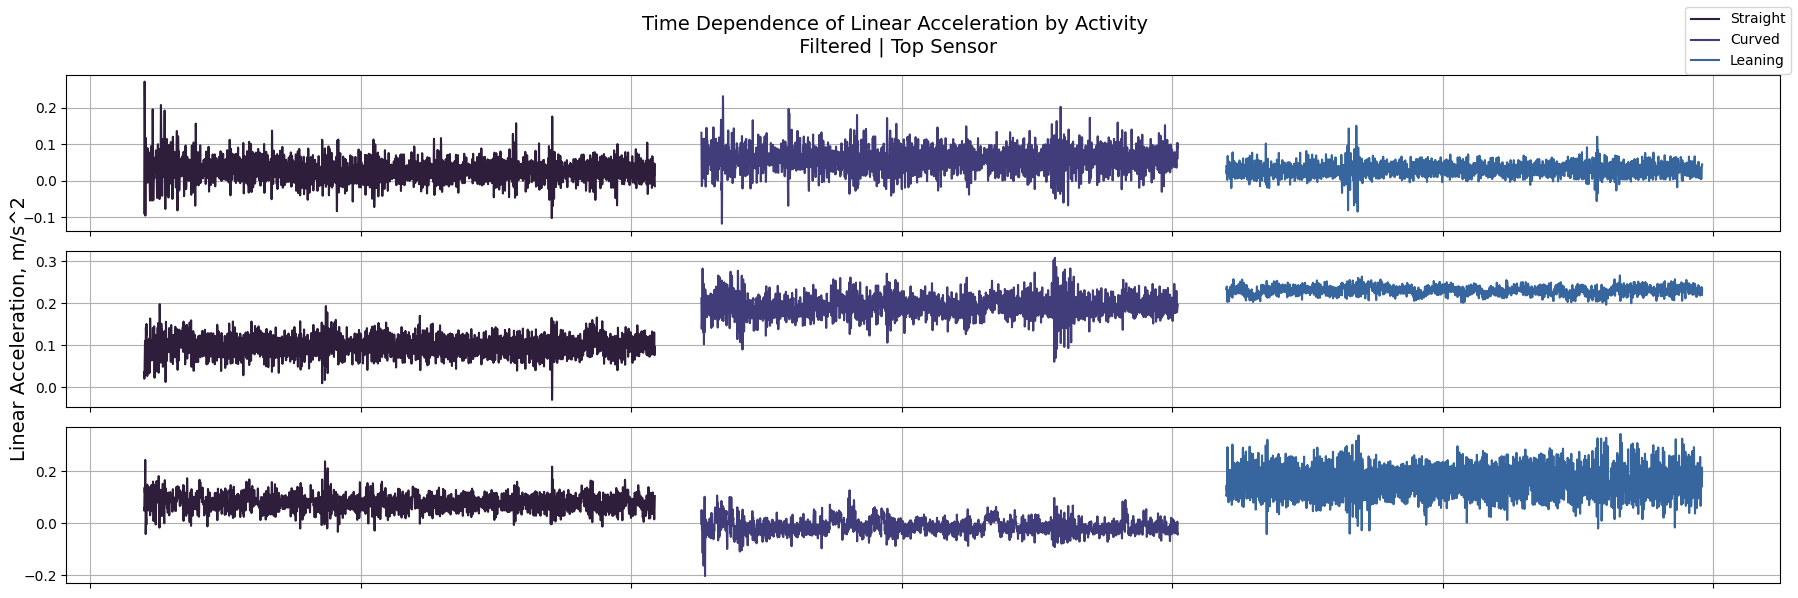

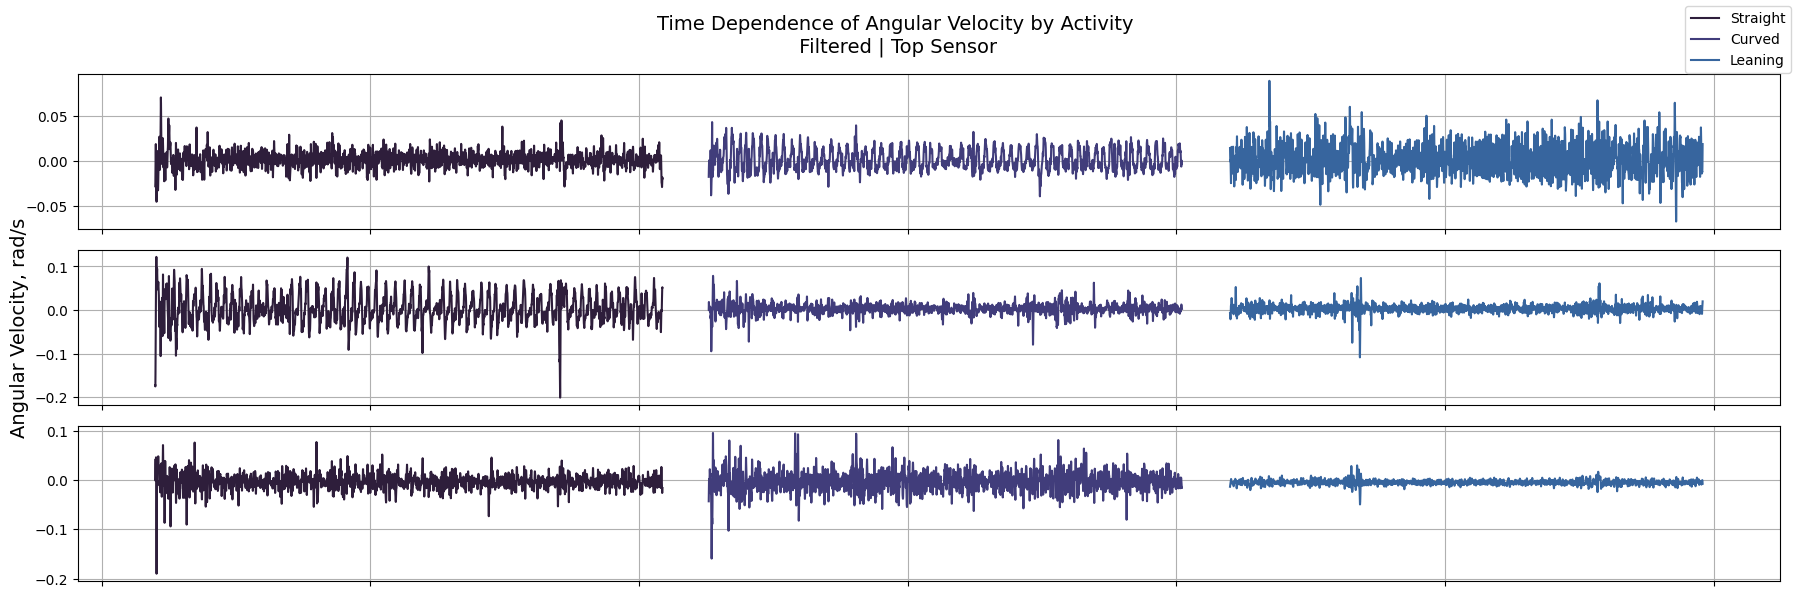

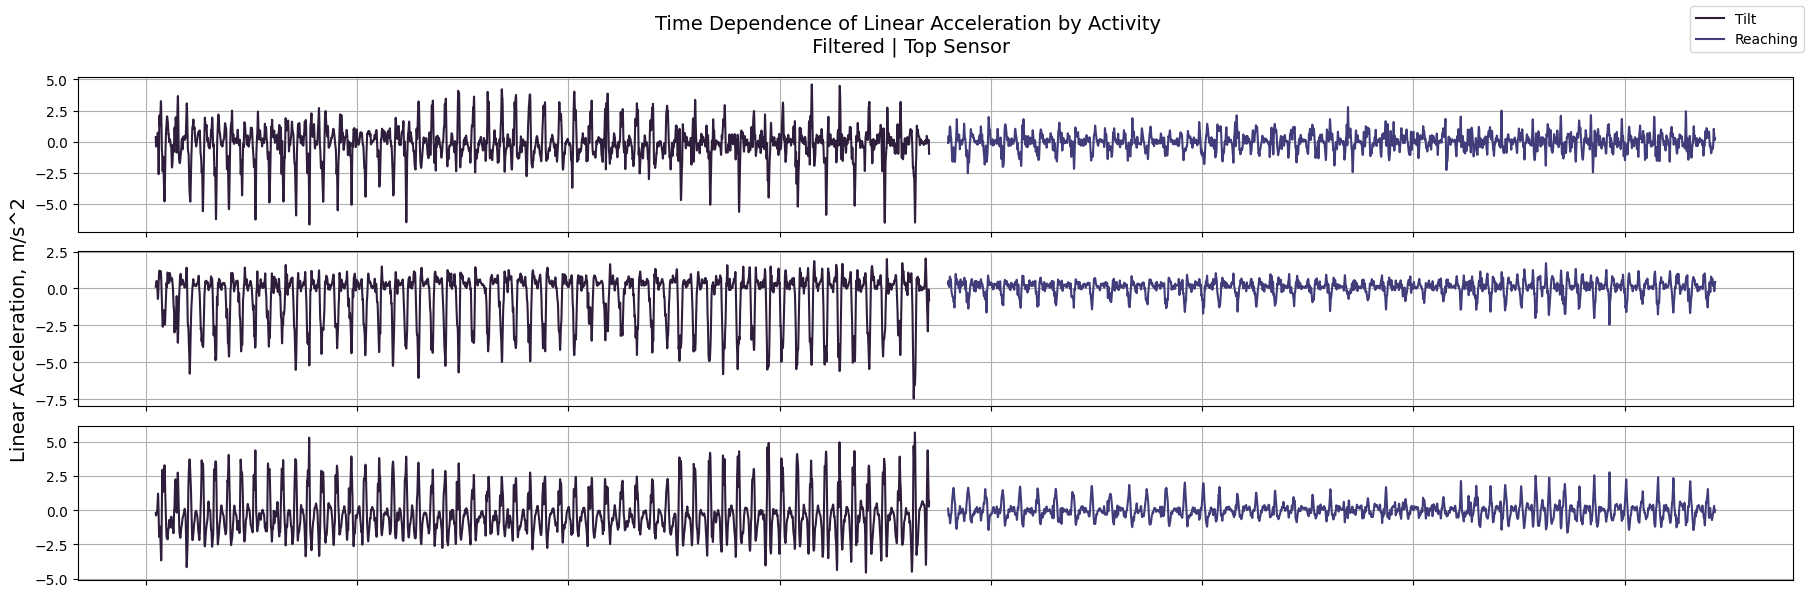

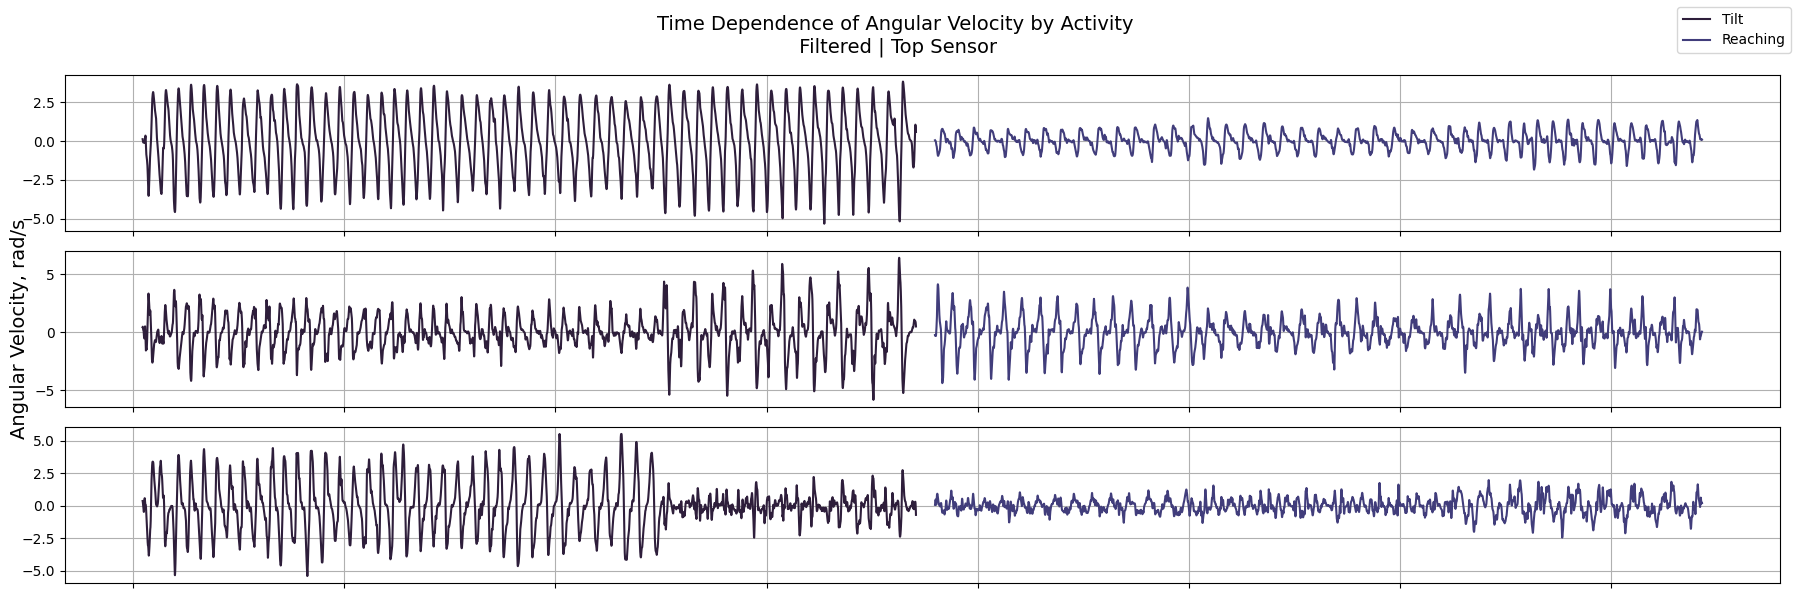

In [23]:
plot_time_dependence(top_filtered_df[(top_filtered_df['label'] != 'Tilt') & (top_filtered_df['label'] != 'Reaching') & (top_filtered_df['label'] != 'Undefined')], ['ftop_acc_x', 'ftop_acc_y', 'ftop_acc_z'], 'Linear Acceleration, m/s^2', 'Time Dependence of Linear Acceleration by Activity\n Filtered | Top Sensor')
plot_time_dependence(top_filtered_df[(top_filtered_df['label'] != 'Tilt') & (top_filtered_df['label'] != 'Reaching') & (top_filtered_df['label'] != 'Undefined')], ['ftop_gyr_x', 'ftop_gyr_y', 'ftop_gyr_z'], 'Angular Velocity, rad/s', 'Time Dependence of Angular Velocity by Activity\n Filtered | Top Sensor')
plot_time_dependence(top_filtered_df[(top_filtered_df['label'] == 'Tilt') | (top_filtered_df['label'] == 'Reaching') & (top_filtered_df['label'] != 'Undefined')], ['ftop_acc_x', 'ftop_acc_y', 'ftop_acc_z'], 'Linear Acceleration, m/s^2', 'Time Dependence of Linear Acceleration by Activity\n Filtered | Top Sensor')
plot_time_dependence(top_filtered_df[(top_filtered_df['label'] == 'Tilt') | (top_filtered_df['label'] == 'Reaching') & (top_filtered_df['label'] != 'Undefined')], ['ftop_gyr_x', 'ftop_gyr_y', 'ftop_gyr_z'], 'Angular Velocity, rad/s', 'Time Dependence of Angular Velocity by Activity\n Filtered | Top Sensor')

In [24]:
for column in down_filtered_df.columns[2:]:
    down_filtered_df[column] = butter_lowpass_filter(down_filtered_df[column], cutoff_frequency, sample_rate)

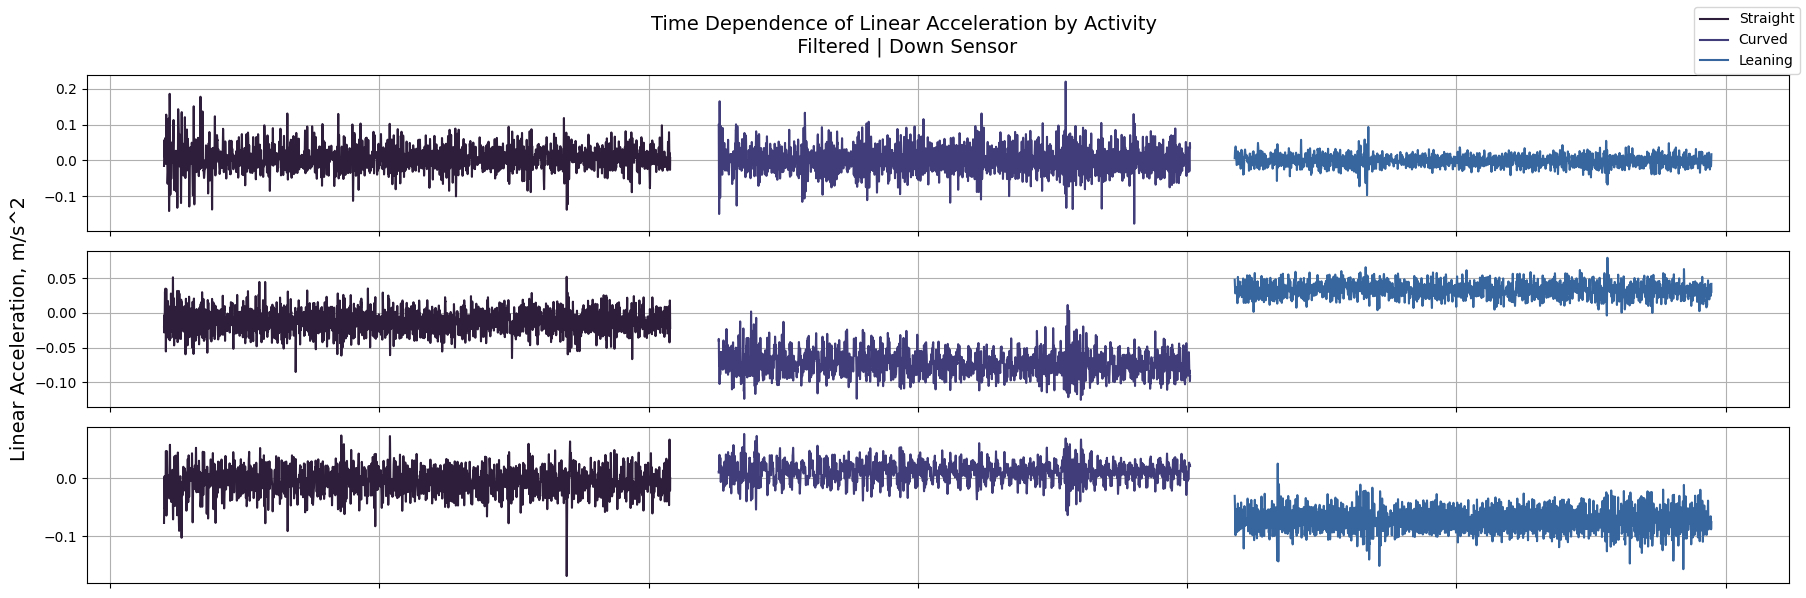

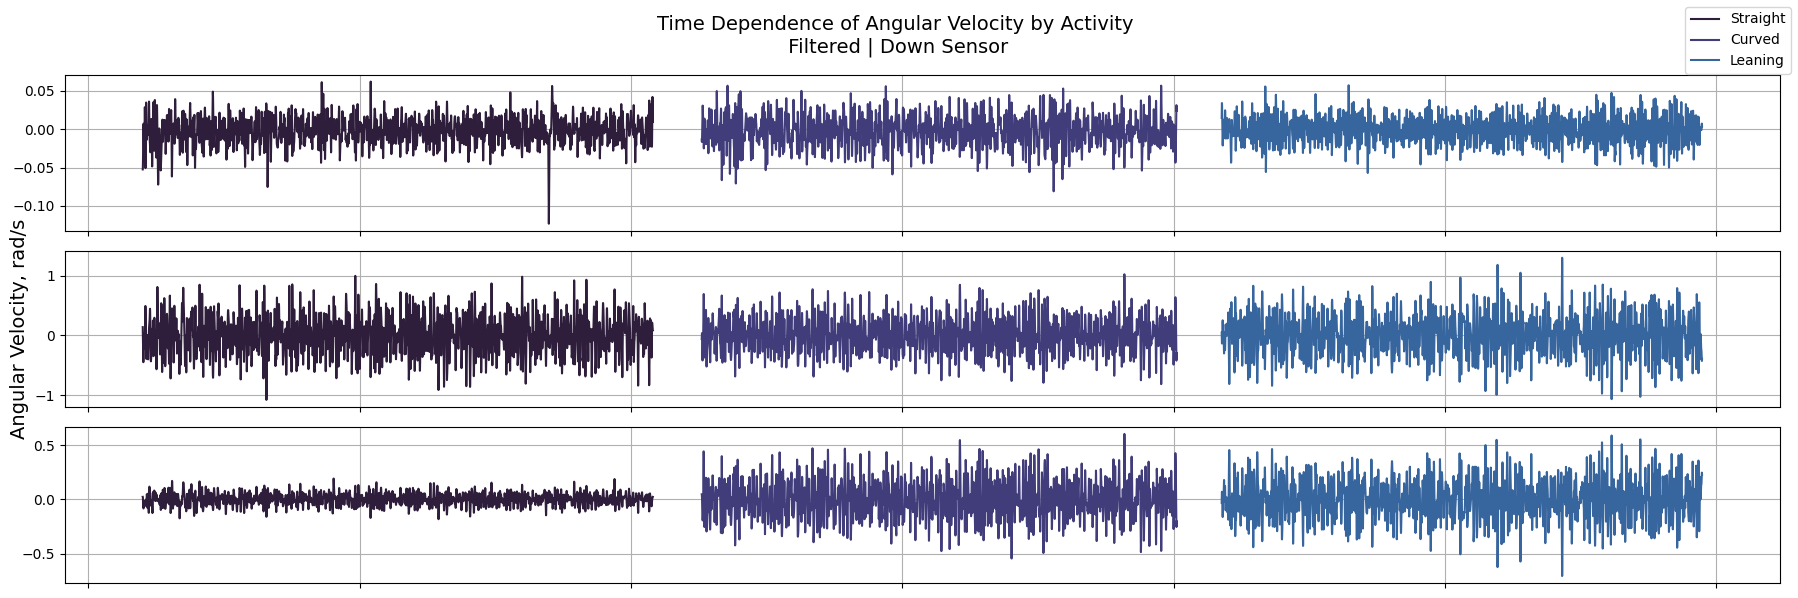

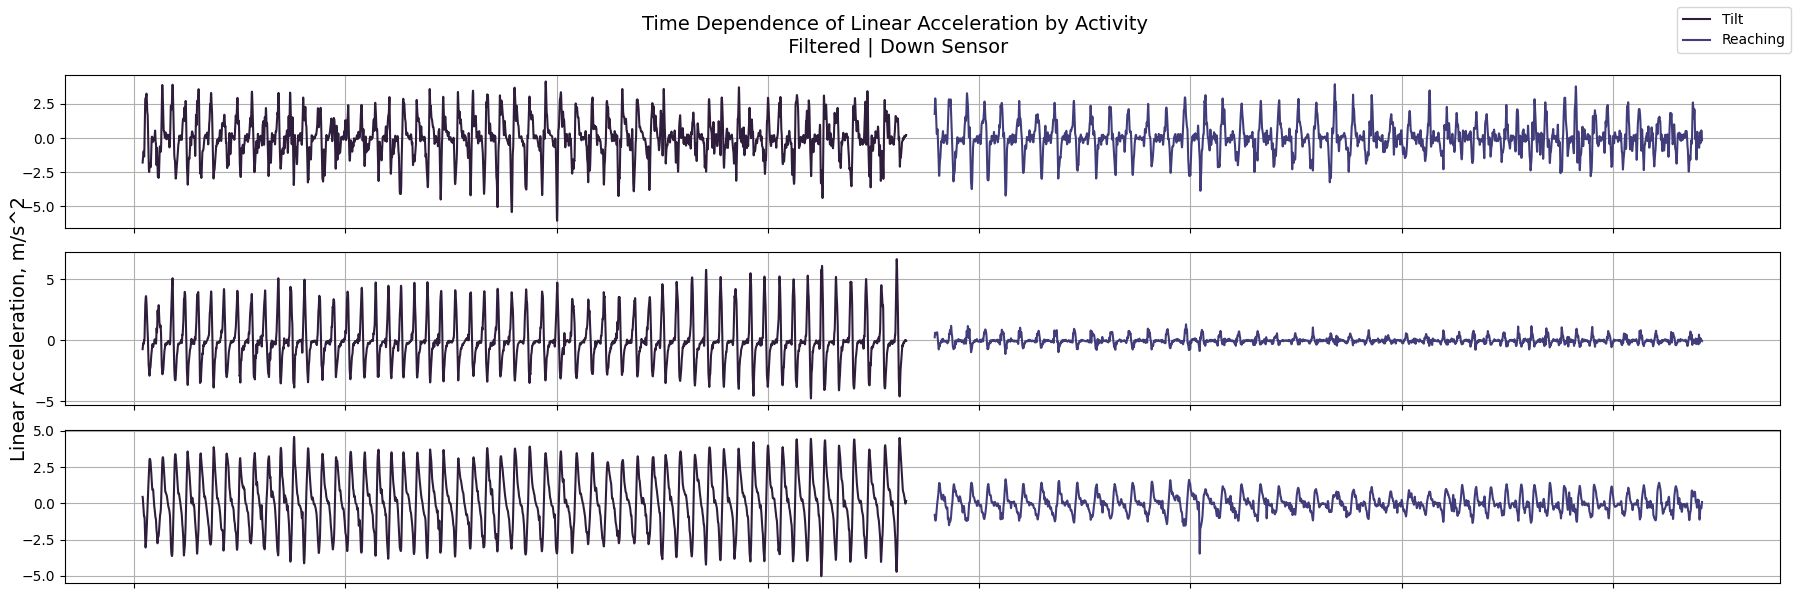

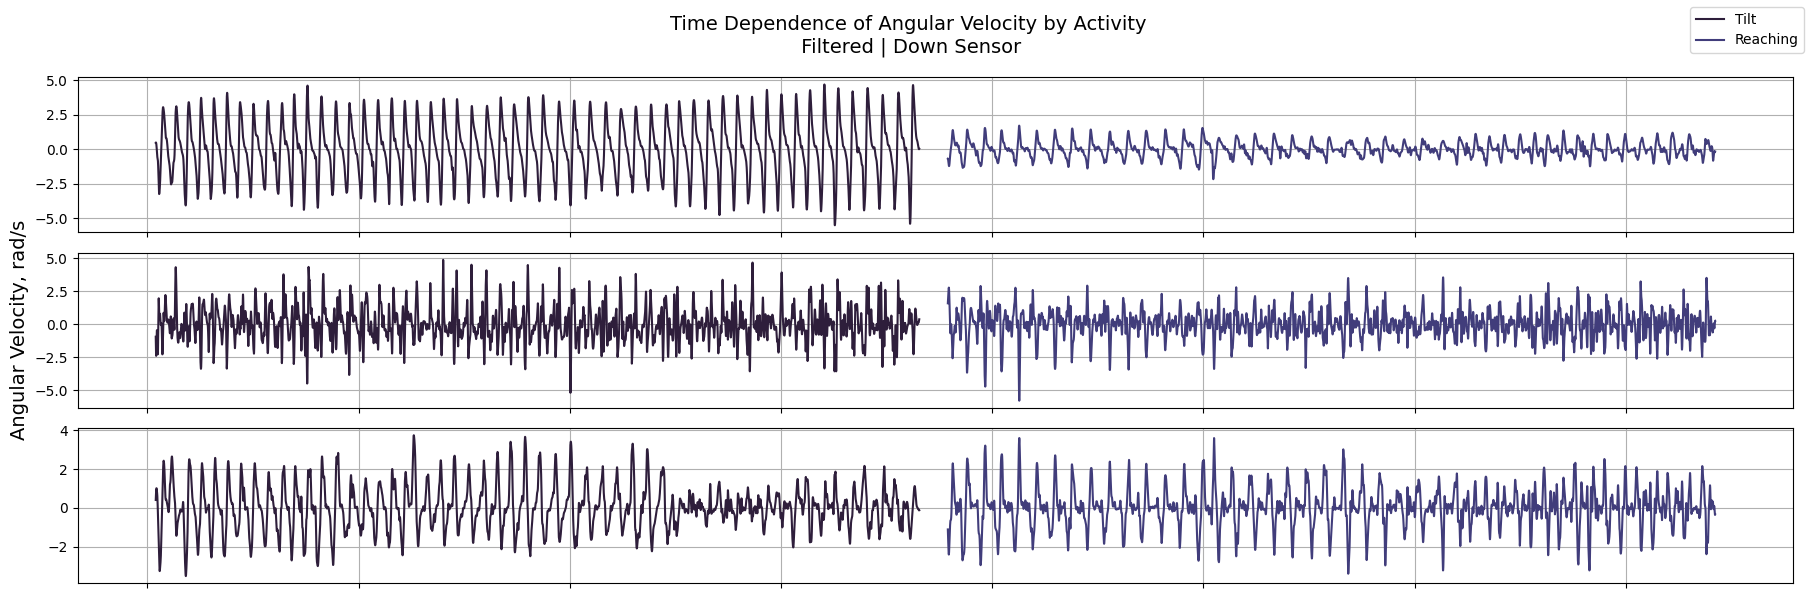

In [25]:
plot_time_dependence(down_filtered_df[(down_filtered_df['label'] != 'Tilt') & (down_filtered_df['label'] != 'Reaching') & (down_filtered_df['label'] != 'Undefined')], ['fdown_acc_x', 'fdown_acc_y', 'fdown_acc_z'], 'Linear Acceleration, m/s^2', 'Time Dependence of Linear Acceleration by Activity\n Filtered | Down Sensor')
plot_time_dependence(down_filtered_df[(down_filtered_df['label'] != 'Tilt') & (down_filtered_df['label'] != 'Reaching') & (down_filtered_df['label'] != 'Undefined')], ['fdown_gyr_x', 'fdown_gyr_y', 'fdown_gyr_z'], 'Angular Velocity, rad/s', 'Time Dependence of Angular Velocity by Activity\n Filtered | Down Sensor')
plot_time_dependence(down_filtered_df[(down_filtered_df['label'] == 'Tilt') | (down_filtered_df['label'] == 'Reaching') & (down_filtered_df['label'] != 'Undefined')], ['fdown_acc_x', 'fdown_acc_y', 'fdown_acc_z'], 'Linear Acceleration, m/s^2', 'Time Dependence of Linear Acceleration by Activity\n Filtered | Down Sensor')
plot_time_dependence(down_filtered_df[(down_filtered_df['label'] == 'Tilt') | (down_filtered_df['label'] == 'Reaching') & (down_filtered_df['label'] != 'Undefined')], ['fdown_gyr_x', 'fdown_gyr_y', 'fdown_gyr_z'], 'Angular Velocity, rad/s', 'Time Dependence of Angular Velocity by Activity\n Filtered | Down Sensor')

Saving the processed dataset

In [26]:
result_df = pd.DataFrame(columns=['label',
                                  'ftop_acc_x', 'ftop_acc_y', 'ftop_acc_z', 
                                  'ftop_gyr_x', 'ftop_gyr_y', 'ftop_gyr_z',
                                  'fdown_acc_x', 'fdown_acc_y', 'fdown_acc_z', 
                                  'fdown_gyr_x', 'fdown_gyr_y', 'fdown_gyr_z'])

top_columns = ['label', 'ftop_acc_x', 'ftop_acc_y', 'ftop_acc_z', 'ftop_gyr_x', 'ftop_gyr_y', 'ftop_gyr_z']
down_columns = ['fdown_acc_x', 'fdown_acc_y', 'fdown_acc_z', 'fdown_gyr_x', 'fdown_gyr_y', 'fdown_gyr_z']
result_df = pd.concat([result_df, pd.concat([top_filtered_df[top_filtered_df['label'] == 'Straight'].iloc[66:-6][top_columns].reset_index(drop=True), 
                        down_filtered_df[down_filtered_df['label'] == 'Straight'].iloc[:-115][down_columns].reset_index(drop=True)], axis=1)], ignore_index=0)
result_df = pd.concat([result_df, pd.concat([top_filtered_df[top_filtered_df['label'] == 'Curved'].iloc[67:-69][top_columns].reset_index(drop=True), 
                        down_filtered_df[down_filtered_df['label'] == 'Curved'].iloc[:-158][down_columns].reset_index(drop=True)], axis=1)], ignore_index=0)
result_df = pd.concat([result_df, pd.concat([top_filtered_df[top_filtered_df['label'] == 'Leaning'].iloc[:-26][top_columns].reset_index(drop=True), 
                        down_filtered_df[down_filtered_df['label'] == 'Leaning'].iloc[50:-106][down_columns].reset_index(drop=True)], axis=1)], ignore_index=0)
result_df = pd.concat([result_df, pd.concat([top_filtered_df[top_filtered_df['label'] == 'Tilt'].iloc[50:-36][top_columns].reset_index(drop=True), 
                        down_filtered_df[down_filtered_df['label'] == 'Tilt'].iloc[:-42][down_columns].reset_index(drop=True)], axis=1)], ignore_index=0)
result_df = pd.concat([result_df, pd.concat([top_filtered_df[top_filtered_df['label'] == 'Reaching'].iloc[49:-62][top_columns].reset_index(drop=True), 
                        down_filtered_df[down_filtered_df['label'] == 'Reaching'].iloc[:-186][down_columns].reset_index(drop=True)], axis=1)], ignore_index=0)

result_df.to_csv('data/filtered_data.csv', index=False)